1. self attentions
2. causal attention
3. Multi head attention
4. if we have embeddings that represents words and their semantic meanings , why do we again need self attention?

In [1]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [2]:
query = inputs[1]  # 2nd input - " journey " token is the query - dim same as dmodel=3

attn_scores_2 = torch.empty(inputs.shape[0]) # empty tensor vector to store attention scores

for i, x_i in enumerate(inputs): # iterate over the words vectors and do the dot products
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [5]:
#The main goal behind the normalization is to obtain attention weights that sum up to 1.
#This normalization is a convention that is useful for interpretation and for maintaining training stability in an LLM.
#Here's a straightforward method for achieving this normalization step:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())
## unnormalized - attention scores  - - - >> once normalized - attention weights
## problems - 1/400 and 400/400 will ask the  model to neglect 1/400, that why avoid sum-normalization and SOFTMAX BASED normalization
#In addition, the softmax function ensures that the attention weights are always positive. 
# This makes the output interpretable as probabilities or relative importance, where higher weights indicate greater importance.

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


PyTorch does not compute the naïve formula: 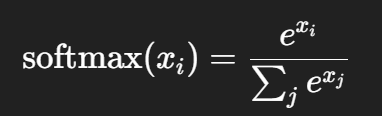


*. Because this is numerically unstable (overflow for large values).
1. PyTorch first subtracts the maximum value from each row to avoid numerical overflow (stable softmax).
2. Then it exponentiates the shifted values and sums them along the given dimension.
3. Finally, it divides each exponential by the sum, producing a normalized probability distribution.
4. 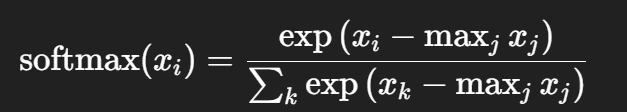

In [4]:
#SOFTMAX BASED normalization
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


# NOW WE DO THIS

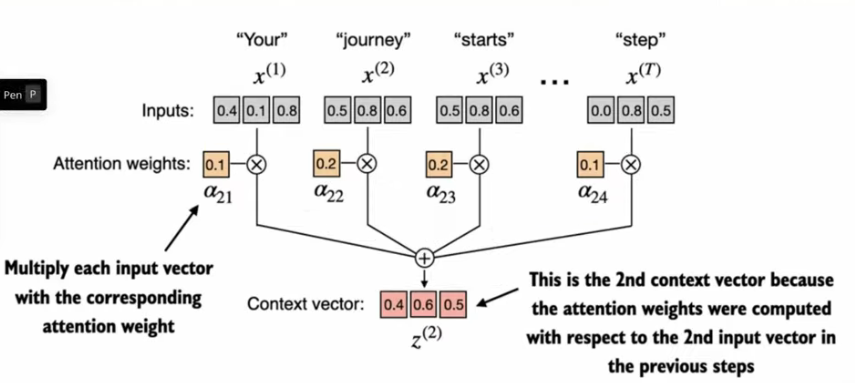

In [11]:
# now we do attention_weights * value vectors

query = inputs[1]# dim same as dmodel=3

context_vec_2 = torch.zeros(query.shape) #this is the outout of (softmax(QK⊤)⋅V) FOR JOURNEY VECTOR , dim same as dmodel=3

for i,x_i in enumerate(inputs):
    #LOOP THROUGH ALL THE VALUE VECTORS OF WORDS AND SCALE/MULTIPLY AND SO THE SUM
    context_vec_2 += attn_weights_2[i]*x_i # 
    print(attn_weights_2[i],'  x  ',x_i, ' = ',context_vec_2)
    

print('\n\n',context_vec_2)
# 

tensor(0.1385)   x   tensor([0.4300, 0.1500, 0.8900])  =  tensor([0.0596, 0.0208, 0.1233])
tensor(0.2379)   x   tensor([0.5500, 0.8700, 0.6600])  =  tensor([0.1904, 0.2277, 0.2803])
tensor(0.2333)   x   tensor([0.5700, 0.8500, 0.6400])  =  tensor([0.3234, 0.4260, 0.4296])
tensor(0.1240)   x   tensor([0.2200, 0.5800, 0.3300])  =  tensor([0.3507, 0.4979, 0.4705])
tensor(0.1082)   x   tensor([0.7700, 0.2500, 0.1000])  =  tensor([0.4340, 0.5250, 0.4813])
tensor(0.1581)   x   tensor([0.0500, 0.8000, 0.5500])  =  tensor([0.4419, 0.6515, 0.5683])


 tensor([0.4419, 0.6515, 0.5683]) this operation updates each word’s embedding so it becomes contextually aware of the other words in the sentence.


# calulation for all the words

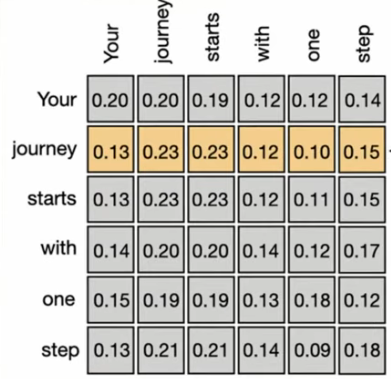

In [23]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)


# easier method rather than doing loop
attn_scores = inputs @ inputs.T
print('\n\n - @ method with Transpose \n',attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


 - @ method with Transpose 
 tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [15]:
attn_weights = torch.softmax(attn_scores, dim=-1) #-1 is to specify softmax to normalize across the columns[ - - - - ]
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [26]:
sum([0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452])

0.9999

In [16]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


# Trainable weights for QKV

In [71]:
x_2 = inputs[1] #A
d_in = inputs.shape[1] #B
d_out = inputs.shape[1] #C

torch.manual_seed(123)
W_query = torch.nn.Linear(d_in, d_out)
W_key = torch.nn.Linear(d_in, d_out)
W_value = torch.nn.Linear(d_in, d_out)

for x in [W_query,W_key,W_value]:
    for param in x.parameters():
        param.requires_grad = False

In [72]:
query = W_query(inputs)
keys = W_key(inputs)
values = W_value(inputs)
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 3])
values.shape: torch.Size([6, 3])


In [73]:
query @ keys.T

tensor([[-0.2173, -0.2780, -0.2731, -0.2499, -0.1586, -0.3002],
        [-0.6607, -0.5641, -0.5543, -0.4934, -0.3376, -0.5938],
        [-0.6516, -0.5573, -0.5477, -0.4873, -0.3335, -0.5865],
        [-0.3954, -0.3047, -0.3003, -0.2375, -0.1890, -0.2847],
        [-0.2972, -0.2652, -0.2612, -0.2145, -0.1605, -0.2571],
        [-0.5065, -0.3916, -0.3856, -0.3170, -0.2411, -0.3807]])

In [74]:
d_k = keys.shape[-1]
d_k

3

In [75]:
#
torch.softmax(query @ keys.T / d_k**0.5, dim=-1)@values

tensor([[0.0948, 0.6463, 0.4296],
        [0.0972, 0.6546, 0.4292],
        [0.0972, 0.6544, 0.4292],
        [0.0982, 0.6516, 0.4290],
        [0.0970, 0.6493, 0.4292],
        [0.0984, 0.6533, 0.4289]])

In [77]:
from torch import nn as nn
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

In [79]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(3, 3)
print(sa_v2(inputs))

tensor([[ 0.4162, -0.4953,  0.0470],
        [ 0.4154, -0.4957,  0.0476],
        [ 0.4155, -0.4957,  0.0476],
        [ 0.4173, -0.5006,  0.0483],
        [ 0.4178, -0.4996,  0.0477],
        [ 0.4166, -0.4996,  0.0483]], grad_fn=<MmBackward0>)


## HIDING FUTURE WORDS WITH CAUSAL ATTENTION


<div class="alert alert-block alert-success">
1. pass the inputs through Key,value and query vectors   

    
    queries = sa_v2.W_query(inputs) #A      
    keys = sa_v2.W_key(inputs)      
    attn_scores = queries @ keys.T      
   
    !do not normalize it now

2. Create a mask of same as context window as we are sending same number of inputs    
    mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)

3. Now apply the mask to the atten scores   
   masked = attn_scores.masked_fill(mask.bool(), -torch.inf)


4. Normalize it now with softmax   
   attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)


</div>

In [11]:
import torch
from torch import nn as nn
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

In [12]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [13]:
torch.manual_seed(789)
d_in=d_out=3
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[ 0.4162, -0.4953,  0.0470],
        [ 0.4154, -0.4957,  0.0476],
        [ 0.4155, -0.4957,  0.0476],
        [ 0.4173, -0.5006,  0.0483],
        [ 0.4178, -0.4996,  0.0477],
        [ 0.4166, -0.4996,  0.0483]], grad_fn=<MmBackward0>)


In [14]:
queries = sa_v2.W_query(inputs) #A
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T

context_length = attn_scores.shape[0]
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[-0.2382,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.3270, -0.3568,    -inf,    -inf,    -inf,    -inf],
        [-0.3218, -0.3506, -0.3384,    -inf,    -inf,    -inf],
        [-0.1822, -0.2026, -0.1975, -0.1128,    -inf,    -inf],
        [-0.1385, -0.1401, -0.1312, -0.0915,  0.0668,    -inf],
        [-0.2439, -0.2754, -0.2699, -0.1499, -0.0948, -0.2134]],
       grad_fn=<MaskedFillBackward0>)


In [16]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1) # applying softmax
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5043, 0.4957, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3362, 0.3307, 0.3330, 0.0000, 0.0000, 0.0000],
        [0.2487, 0.2458, 0.2465, 0.2589, 0.0000, 0.0000],
        [0.1939, 0.1937, 0.1947, 0.1993, 0.2183, 0.0000],
        [0.1631, 0.1602, 0.1607, 0.1722, 0.1778, 0.1660]],
       grad_fn=<SoftmaxBackward0>)


## DROPOUTS
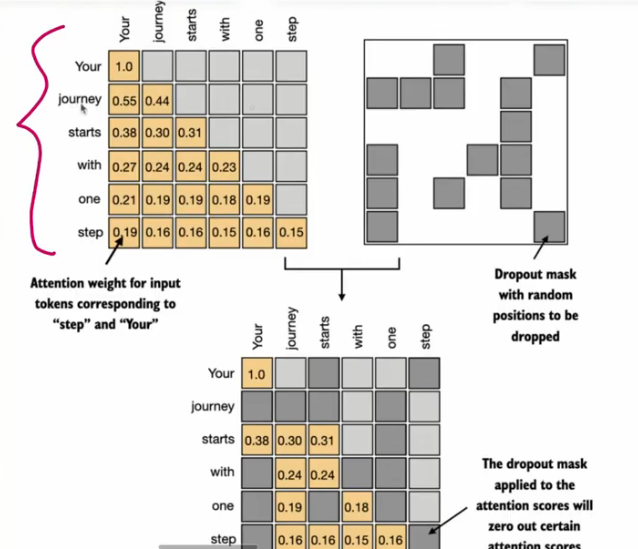



<div class="alert alert-block alert-success">

In the following code example, we use a dropout rate of 50%, which means masking out
half of the attention weights.

When we train the GPT model in later chapters, we will use a
lower dropout rate, such as 0.1 or 0.2.

 *** IMPORTANT ***

 
When applying dropout to an attention weight matrix with a rate of 50%, half of the
elements in the matrix are randomly set to zero.

 *** IMPORTANT ***


 
To compensate for the reduction in active
elements, the values of the remaining elements in the matrix are scaled up by a factor of
1/0.5 =2. 

This scaling is crucial to maintain the overall balance of the attention weights,
ensuring that the average influence of the attention mechanism remains consistent during
both the training and inference phases.
</div>

In [17]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #A
example = torch.ones(6, 6) #B
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [20]:
## check how the numbers which are avialable is scaled to 2*
torch.manual_seed(123)
print(attn_weights,'\n\n',dropout(attn_weights))

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5043, 0.4957, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3362, 0.3307, 0.3330, 0.0000, 0.0000, 0.0000],
        [0.2487, 0.2458, 0.2465, 0.2589, 0.0000, 0.0000],
        [0.1939, 0.1937, 0.1947, 0.1993, 0.2183, 0.0000],
        [0.1631, 0.1602, 0.1607, 0.1722, 0.1778, 0.1660]],
       grad_fn=<SoftmaxBackward0>) 

 tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6725, 0.6614, 0.6661, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4916, 0.4931, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3875, 0.0000, 0.3985, 0.0000, 0.0000],
        [0.0000, 0.3204, 0.3214, 0.3444, 0.3556, 0.0000]],
       grad_fn=<MulBackward0>)


<div class="alert alert-block alert-success">
Before we begin, one more thing is to ensure that the code can handle batches
consisting of more than one input. 

This will ensure that the CausalAttention class supports the batch
outputs produced by the data loader we implemented earlier.

For simplicity, to simulate such batch inputs, we duplicate the input text example:


In [21]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


In [22]:
batch

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

In [23]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # 1,2 because ,to transpose token_size*d_model, ignore batch size
        
        attn_scores.masked_fill_( self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

In [24]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 3])


In [26]:
attn_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5043, 0.4957, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3362, 0.3307, 0.3330, 0.0000, 0.0000, 0.0000],
        [0.2487, 0.2458, 0.2465, 0.2589, 0.0000, 0.0000],
        [0.1939, 0.1937, 0.1947, 0.1993, 0.2183, 0.0000],
        [0.1631, 0.1602, 0.1607, 0.1722, 0.1778, 0.1660]],
       grad_fn=<SoftmaxBackward0>)

In [28]:
context_vecs

tensor([[[ 0.3326,  0.5659, -0.3132],
         [ 0.3456,  0.5650, -0.2237],
         [ 0.3440,  0.5604, -0.2000],
         [ 0.3103,  0.4941, -0.1606],
         [ 0.2430,  0.4287, -0.1643],
         [ 0.2648,  0.4316, -0.1375]],

        [[ 0.3326,  0.5659, -0.3132],
         [ 0.3456,  0.5650, -0.2237],
         [ 0.3440,  0.5604, -0.2000],
         [ 0.3103,  0.4941, -0.1606],
         [ 0.2430,  0.4287, -0.1643],
         [ 0.2648,  0.4316, -0.1375]]], grad_fn=<UnsafeViewBackward0>)

# MULTIHEAD ATTENTION

Embeddings are multiplied by W_Q, W_K, W_V to create Q, K, V projections, which are no longer embeddings.   
These projections are then reshaped into multiple heads in Multi-Head Attention (MHA).   
Each head computes attention scores = Q · Kᵀ to measure how much one token should attend to another.   
Softmax converts these scores into attention weights, deciding the importance of each token.   
Each head uses these weights to mix V, and all heads are concatenated to form the final contextual representation.   

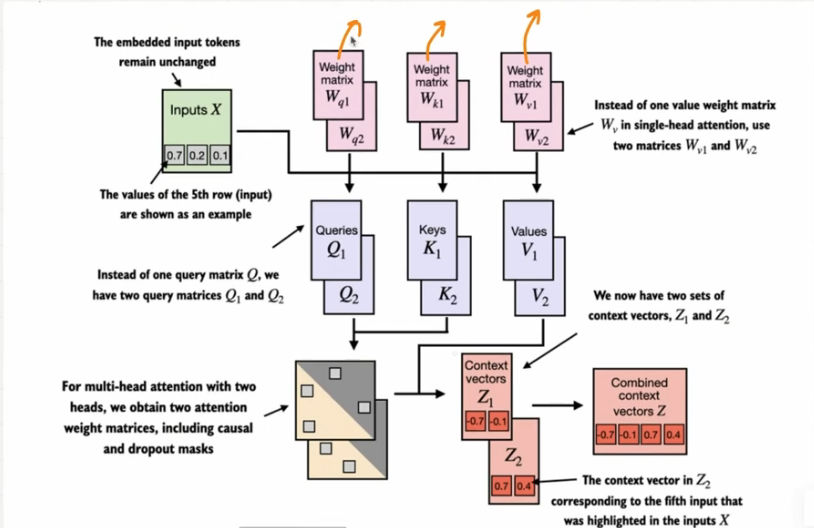

1. BELOW CODE REFERENCE 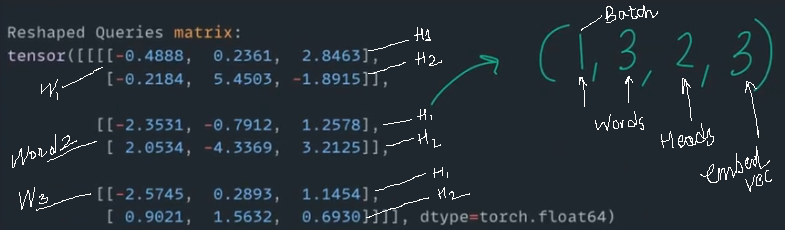

2. BELOW CODE REFERENCE 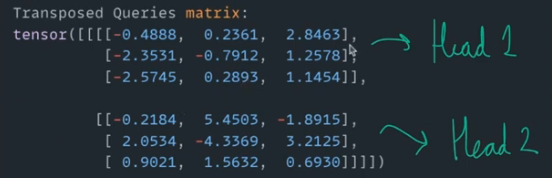

3. BELOW CODE REFERENCE 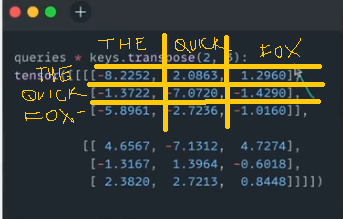

4. BELOW CODE REFERENCE 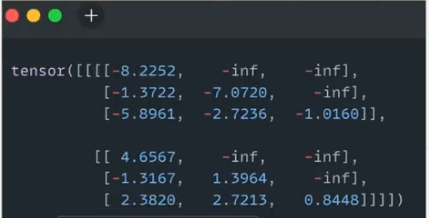

5. BELOW CODE REFERENC 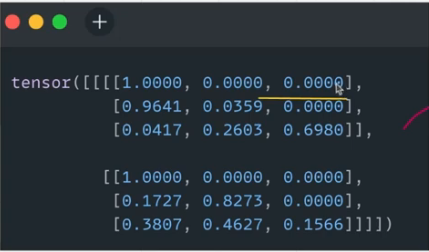

6. BELOW CODE REFERENe 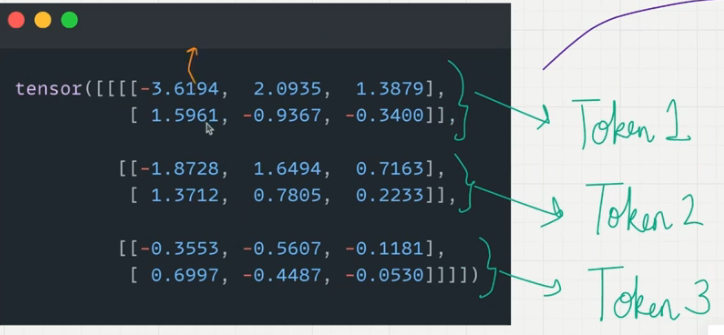

7.BELOW CODE REFERENe 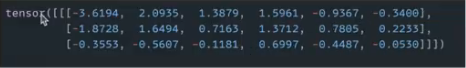

In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # SPLIT THE DMODEL - WORD EMB VECTOR BY # HEADS, SO EACH HEAD GET EQ LEN VEC

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # ROWS OF INPUT = num_tokens , NUMBER OF TOKENS
        # COLUMNS OF INPUT = DMODEL , EMBEDDING VEC DIMEN
        # NOW MANY BATCH OF X*Y

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        
        #tensor.view(a, b, c, d) only reshapes the underlying memory without copying or splitting anything.
        # REFER TO IMAGE 1
        
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        # this is grouping the values by heads SO THAT WE CAN COMPUTE THE HEADS SEPARATELY & PARALELLY
        # REFER TO IMAGE 2
        
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        # REFER TO IMAGE 3
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        # REFER TO IMAGE 4
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # REFER TO IMAGE 5
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        # REFER TO IMAGE 6
        #important -  here we are bringing back the matrix into image 1 format so that we can concat
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
         # REFER TO IMAGE 7
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [30]:
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573], #A
[0.8993, 0.0390, 0.9268, 0.7388],
[0.7179, 0.7058, 0.9156, 0.4340]],
[[0.0772, 0.3565, 0.1479, 0.5331],
[0.4066, 0.2318, 0.4545, 0.9737],
[0.4606, 0.5159, 0.4220, 0.5786]]]])